# \[Rahib\]- Project 1

## TOP 3 Problems:

## Top 1

## Q7 (complex)

Write a query that provides insights into the top-performing customers and products for each month

Tables Involved: Sales.Invoices, Sales.InvoiceLines, Sales.Customers, Warehouse.StockItems

\*Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query\*  

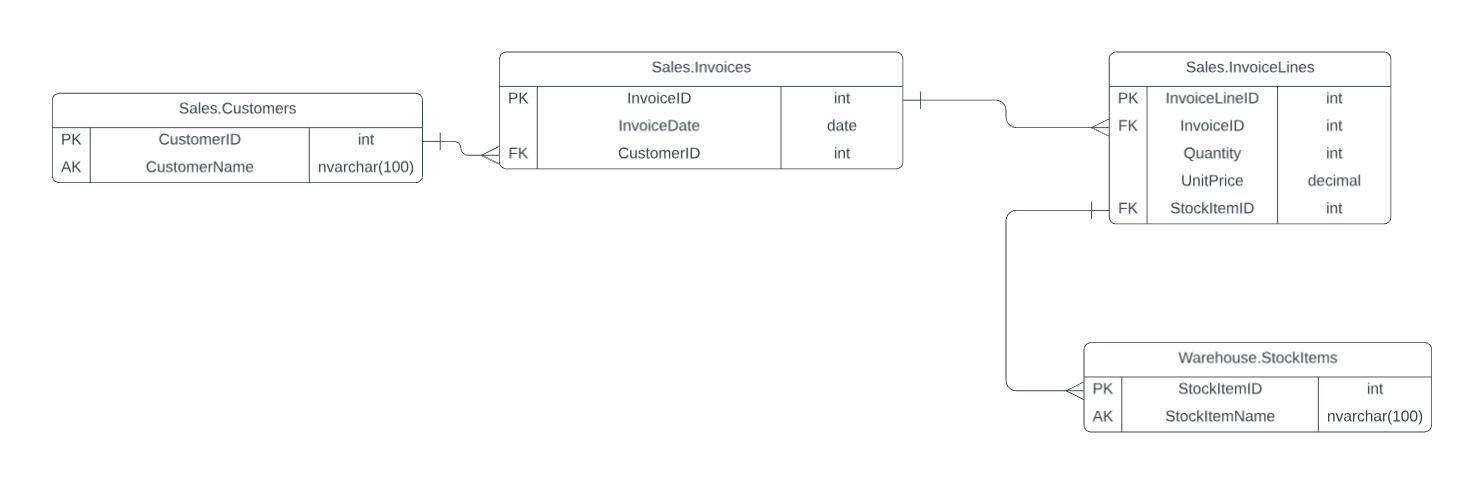

In [ ]:
use WideWorldImporters
;WITH MonthlySales AS (
    SELECT
        YEAR(InvoiceDate) AS InvoiceYear,
        MONTH(InvoiceDate) AS InvoiceMonth,
        CustomerID,
        SUM(Quantity*UnitPrice) AS MonthlyTotalSales
    FROM
        Sales.Invoices i
    join 
        Sales.InvoiceLines il on il.InvoiceID =i.InvoiceID
    GROUP BY
        YEAR(InvoiceDate),
        MONTH(InvoiceDate),
        CustomerID
),
TopCustomers AS (
    SELECT
        InvoiceYear,
        InvoiceMonth,
        CustomerID,
        MonthlyTotalSales,
        ROW_NUMBER() OVER(PARTITION BY InvoiceYear, InvoiceMonth ORDER BY MonthlyTotalSales DESC) AS CustomerRank
    FROM
        MonthlySales
),
ProductSales AS (
    SELECT
        YEAR(InvoiceDate) AS InvoiceYear,
        MONTH(InvoiceDate) AS InvoiceMonth,
        StockItemID,
        SUM(Quantity * UnitPrice) AS MonthlyProductSales
    FROM
        Sales.Invoices i
    join 
        Sales.InvoiceLines il on i.InvoiceID=il.InvoiceID
    GROUP BY
        YEAR(InvoiceDate),
        MONTH(InvoiceDate),
        StockItemID
),
TopProducts AS (
    SELECT
        InvoiceYear,
        InvoiceMonth,
        StockItemID,
        MonthlyProductSales,
        ROW_NUMBER() OVER(PARTITION BY InvoiceYear, InvoiceMonth ORDER BY MonthlyProductSales DESC) AS ProductRank
    FROM
        ProductSales
)
SELECT
    tc.InvoiceYear,
    tc.InvoiceMonth,
    c.CustomerName,
    tc.MonthlyTotalSales,
    p.StockItemName,
    tp.MonthlyProductSales
FROM
    TopCustomers tc
JOIN
    TopProducts tp ON tc.InvoiceYear = tp.InvoiceYear AND tc.InvoiceMonth = tp.InvoiceMonth
JOIN
    Sales.Customers c ON tc.CustomerID = c.CustomerID
JOIN
    Warehouse.StockItems p ON tp.StockItemID = p.StockItemID
WHERE
    tc.CustomerRank <= 3
    AND tp.ProductRank <= 3
ORDER BY
    tc.InvoiceYear,
    tc.InvoiceMonth,
    tc.MonthlyTotalSales DESC,
    tp.MonthlyProductSales DESC
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES


## Top 2

## Q20 (complex)

Write a query that find the top 3 selling products for each order date month

Tables Involved: Sales.SalesOrderDetail, Production.Product, Sales.SalesOrderHeader

\*<span style="font-family: -apple-system, BlinkMacSystemFont, sans-serif; color: var(--vscode-foreground);">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>

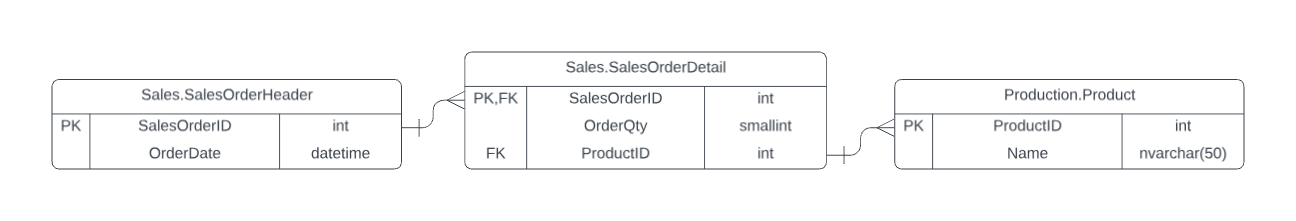

In [ ]:
use AdventureWorks2017
go
drop FUNCTION if EXISTS dbo.CalculateTotalSales;
go
CREATE FUNCTION dbo.CalculateTotalSales (@SalesOrderID INT)
RETURNS MONEY
AS
BEGIN
    DECLARE @TotalSales MONEY;

    SELECT @TotalSales = SUM(LineTotal)
    FROM Sales.SalesOrderDetail
    WHERE SalesOrderID = @SalesOrderID;

    RETURN @TotalSales;
END;
GO
WITH SalesOrderSummary AS (
    SELECT 
        soh.SalesOrderID,
        MONTH(soh.OrderDate) as month,
        p.Name AS ProductName,
        SUM(sod.OrderQty) AS TotalQuantity,
        dbo.CalculateTotalSales(soh.SalesOrderID) AS TotalSales
    FROM 
        Sales.SalesOrderHeader soh
    INNER JOIN 
        Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
    INNER JOIN 
        Production.Product p ON sod.ProductID = p.ProductID
    GROUP BY 
        soh.SalesOrderID,
        MONTH(soh.OrderDate),
        p.Name
),
TopSellingProducts AS (
    SELECT 
        ROW_NUMBER() OVER (PARTITION BY month ORDER BY TotalQuantity DESC) AS Rank,
        MONTH,
        ProductName,
        TotalQuantity
    FROM 
        SalesOrderSummary
)
SELECT 
    [month],
    ProductName,
    TotalQuantity
FROM 
    TopSellingProducts
WHERE 
    Rank <= 3
ORDER BY 
    [month],
    Rank
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES


## Top 3

## Q18 (complex)

Write a query tha provides the percentage from the total sales from each product

Tables Involved: Production.Product, Production.ProductSubcategory,Production.ProductCategory

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

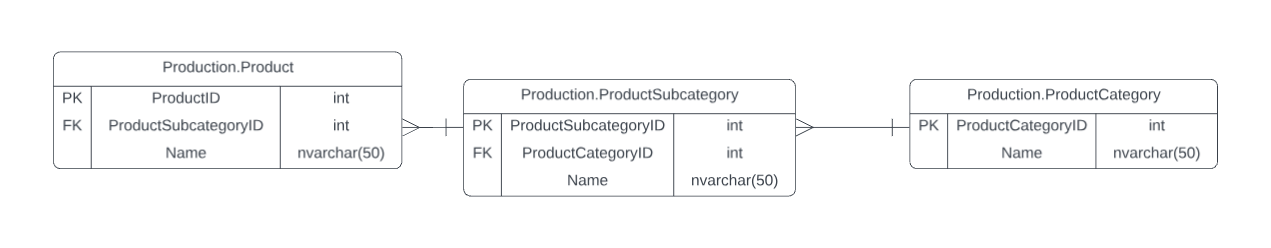

In [ ]:
use AdventureWorks2017;
DROP FUNCTION if EXISTS dbo.CalculateTotalSales
go
CREATE FUNCTION dbo.CalculateTotalSales (@ProductID INT)
RETURNS MONEY
AS
BEGIN
    DECLARE @TotalSales MONEY;

    SELECT @TotalSales = SUM(UnitPrice * OrderQty)
    FROM Sales.SalesOrderDetail
    WHERE ProductID = @ProductID;

    RETURN @TotalSales;
END;
GO
WITH ProductSalesCTE AS (
    SELECT
        PC.Name AS CategoryName,
        P.Name AS ProductName,
        dbo.CalculateTotalSales(P.ProductID) AS TotalSales
    FROM 
        Production.Product P
    INNER JOIN 
        Production.ProductSubcategory PS ON P.ProductSubcategoryID = PS.ProductSubcategoryID
    INNER JOIN 
        Production.ProductCategory PC ON PS.ProductCategoryID = PC.ProductCategoryID
),

CategorySales AS (
    SELECT
        CategoryName,
        SUM(TotalSales) AS CategoryTotalSales
    FROM
        ProductSalesCTE
    GROUP BY
        CategoryName
)
SELECT
    PSC.CategoryName,
    PSC.ProductName,
    PSC.TotalSales,
    (PSC.TotalSales / CS.CategoryTotalSales) * 100 AS PercentageOfTotalSales
FROM
    ProductSalesCTE PSC
INNER JOIN
    CategorySales CS ON PSC.CategoryName = CS.CategoryName
where psc.TotalSales is not null
ORDER BY
    PSC.CategoryName,
    PercentageOfTotalSales DESC
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES;


## Worst 3 Problems:

Prioritize their 3 worst problems (medium, and complex); explain why they chose these problems for their lowest rating. How can the problems be fixed to make them better?

## Worst 1

## Q4(complex)

Write a query that calculates the average quantity, average sales, and average sales with discount of 10% for each month and year

Tables Involved: Salws.SalesOrderHeader, Sales.SalesOrderDeatil, Production.Product

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

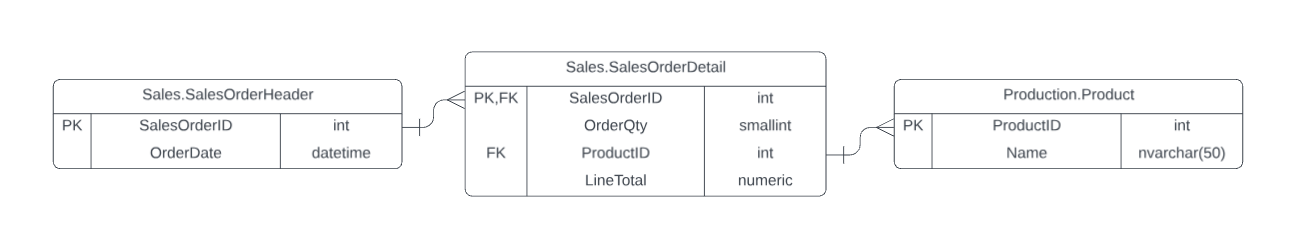

In [ ]:
use AdventureWorks2017
;WITH SalesCTE AS (
    SELECT
        p.Name AS ProductName,
        YEAR(soh.OrderDate) AS OrderYear,
        MONTH(soh.OrderDate) AS OrderMonth,
        SUM(sod.OrderQty) AS TotalQuantity,
        SUM(sod.LineTotal) AS TotalSales
    FROM
        Sales.SalesOrderHeader soh
    INNER JOIN
        Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
    INNER JOIN
        Production.Product p ON sod.ProductID = p.ProductID
    GROUP BY
        p.Name,
        YEAR(soh.OrderDate),
        MONTH(soh.OrderDate)
),
SalesWithDiscountCTE AS (
    SELECT
        sc.ProductName,
        sc.OrderYear,
        sc.OrderMonth,
        sc.TotalQuantity,
        sc.TotalSales,
        0.1 AS DiscountRate
    FROM
        SalesCTE sc
),
FinalSalesCTE AS (
    SELECT
        swd.ProductName,
        swd.OrderYear,
        swd.OrderMonth,
        swd.TotalQuantity,
        swd.TotalSales,
        (swd.TotalSales * (1 - swd.DiscountRate)) AS TotalSalesWithDiscount
    FROM
        SalesWithDiscountCTE swd
)
SELECT
    OrderYear,
    OrderMonth,
    AVG(TotalQuantity) AS AverageQuantity,
    AVG(TotalSales) AS AverageSales,
    AVG(TotalSalesWithDiscount) AS AverageSalesWithDiscount
FROM
    FinalSalesCTE
GROUP BY
    OrderYear,
    OrderMonth
ORDER BY
    OrderYear,
    OrderMonth;
--Fixed

USE AdventureWorks2017;
WITH SalesCTE AS (
    SELECT
        p.Name AS ProductName,
        YEAR(soh.OrderDate) AS OrderYear,
        DATENAME(month, soh.OrderDate) AS OrderMonth, -- Changed to return the name of the month
        SUM(sod.OrderQty) AS TotalQuantity,
        SUM(sod.LineTotal) AS TotalSales
    FROM
        Sales.SalesOrderHeader soh
    INNER JOIN
        Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
    INNER JOIN
        Production.Product p ON sod.ProductID = p.ProductID
    GROUP BY
        p.Name,
        YEAR(soh.OrderDate),
        DATENAME(month, soh.OrderDate) -- Changed to use DATENAME for grouping
),

SalesWithDiscountCTE AS (
    SELECT
        sc.ProductName,
        sc.OrderYear,
        sc.OrderMonth,
        sc.TotalQuantity,
        sc.TotalSales,
        0.1 AS DiscountRate
    FROM
        SalesCTE sc
),

FinalSalesCTE AS (
    SELECT
        swd.ProductName,
        swd.OrderYear,
        swd.OrderMonth,
        swd.TotalQuantity,
        swd.TotalSales,
        (swd.TotalSales * (1 - swd.DiscountRate)) AS TotalSalesWithDiscount
    FROM
        SalesWithDiscountCTE swd
)

SELECT
    OrderYear,
    OrderMonth,
    AVG(TotalQuantity) AS AverageQuantity,
    AVG(TotalSales) AS AverageSales,
    AVG(TotalSalesWithDiscount) AS AverageSalesWithDiscount
FROM
    FinalSalesCTE
GROUP BY
    OrderYear,
    OrderMonth
ORDER BY
    OrderYear,
    CASE
        WHEN OrderMonth = 'January' THEN 1
        WHEN OrderMonth = 'February' THEN 2
        WHEN OrderMonth = 'March' THEN 3
        WHEN OrderMonth = 'April' THEN 4
        WHEN OrderMonth = 'May' THEN 5
        WHEN OrderMonth = 'June' THEN 6
        WHEN OrderMonth = 'July' THEN 7
        WHEN OrderMonth = 'August' THEN 8
        WHEN OrderMonth = 'September' THEN 9
        WHEN OrderMonth = 'October' THEN 10
        WHEN OrderMonth = 'November' THEN 11
        WHEN OrderMonth = 'December' THEN 12
    END
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES;


## Worst 2

## Q5 (medium)

Write a query that returns the total sales amount for each product subcategory in descending order

Tables Involved: FactInternetSales, DimProduct, DimProductSubCategory

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

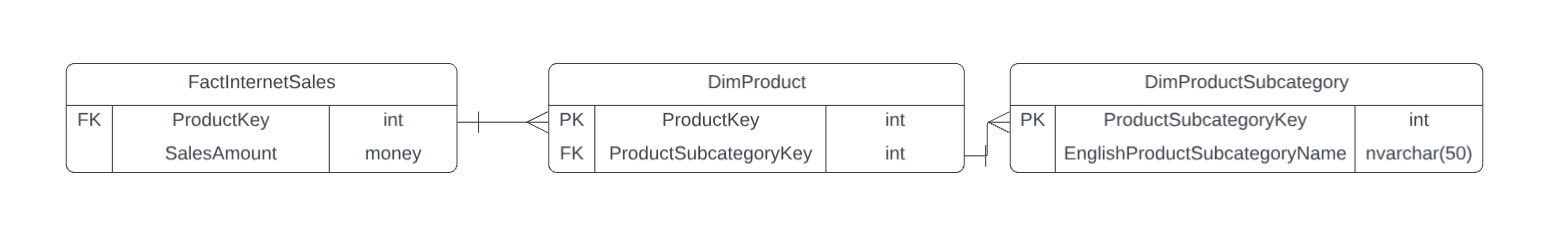

In [ ]:
use AdventureWorksDW2017
SELECT
    dpsc.EnglishProductSubcategoryName,
    SUM(fs.SalesAmount) AS TotalSales
FROM
    FactInternetSales fs
INNER JOIN
    DimProduct dp ON fs.ProductKey = dp.ProductKey
INNER JOIN
    DimProductSubcategory dpsc on dp.ProductSubcategoryKey = dpsc.ProductSubcategoryKey
GROUP BY
    dpsc.EnglishProductSubcategoryName
ORDER BY
    TotalSales DESC
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES;
-- Fixed
use AdventureWorksDW2017
SELECT
    dpsc.EnglishProductSubcategoryName,
    SUM(fs.SalesAmount) AS TotalSales
FROM
    FactInternetSales fs
INNER JOIN
    DimProduct dp ON fs.ProductKey = dp.ProductKey
Right JOIN
    DimProductSubcategory dpsc on dp.ProductSubcategoryKey = dpsc.ProductSubcategoryKey
GROUP BY
    dpsc.EnglishProductSubcategoryName
ORDER BY
    TotalSales DESC
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES;


## Worst 3

## Q12 (medium)

Write a query that returns the top suppliers with the highest total sales amount

Tables Involved: Production.Supplier, Production.Product, Sales.OrderDetail

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

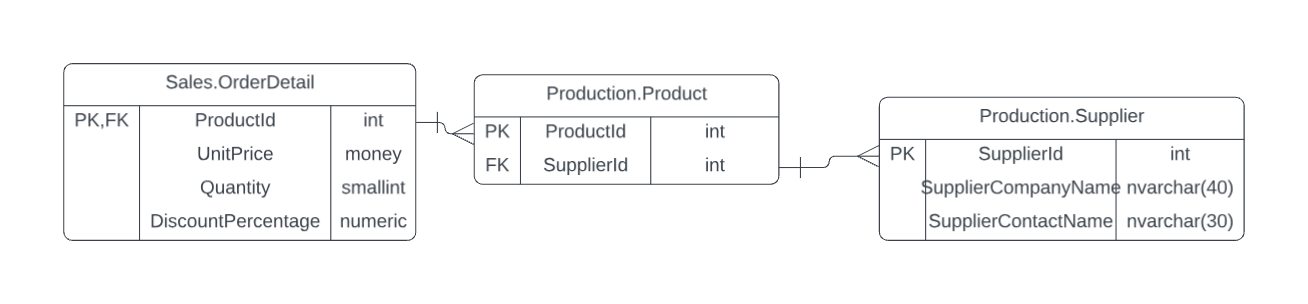

In [ ]:
use Northwinds2022TSQLV7
;WITH SupplierSales AS (
    SELECT 
        s.SupplierID,
        s.SupplierCompanyName,
        s.SupplierContactName,
        SUM(od.Quantity * od.UnitPrice * (1 - od.DiscountPercentage)) AS TotalSalesAmount
    FROM 
        Production.Supplier s
    INNER JOIN 
        Production.Product p ON s.SupplierID = p.SupplierID
    INNER JOIN 
        [Sales].OrderDetail od ON p.ProductID = od.ProductID
    GROUP BY 
        s.SupplierID,
        s.SupplierCompanyName,
        s.SupplierContactName
)

SELECT 
    SupplierCompanyName,
    SupplierContactname,
    TotalSalesAmount
FROM 
    SupplierSales
ORDER BY 
    TotalSalesAmount DESC
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES;
--Fixed
use Northwinds2022TSQLV7
;WITH SupplierSales AS (
    SELECT 
        s.SupplierID,
        s.SupplierContactTitle,
        s.SupplierPhoneNumber,
        s.SupplierContactName,
        SUM(od.Quantity * od.UnitPrice * (1 - od.DiscountPercentage)) AS TotalSalesAmount
    FROM 
        Production.Supplier s
    INNER JOIN 
        Production.Product p ON s.SupplierID = p.SupplierID
    INNER JOIN 
        [Sales].OrderDetail od ON p.ProductID = od.ProductID
    GROUP BY 
        s.SupplierID,
        s.SupplierContactName,
        SupplierContactTitle,
        SupplierPhoneNumber
)

SELECT 
    SupplierContactname,
    SupplierContactTitle,
    SupplierPhoneNumber,
    TotalSalesAmount
FROM 
    SupplierSales
ORDER BY 
    TotalSalesAmount DESC
--FOR JSON PATH, ROOT('ComplexOutput'), INCLUDE_NULL_VALUES;

## Q1 (medium)

Write a query that finds the top 5 customers that spent the most money in total.

Tables Invloved: Sales.Customer, Person.Person, Sales.SalesOrderHeader

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

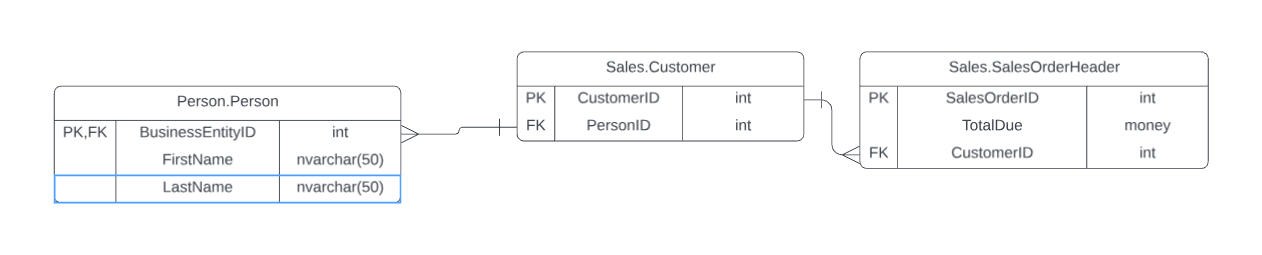

In [ ]:
use AdventureWorks2017
SELECT TOP 5 c.CustomerID, p.FirstName + ' ' + p.LastName AS CustomerName, SUM(soh.TotalDue) AS TotalSpent
FROM Sales.Customer AS c
JOIN Person.Person AS p ON c.PersonID = p.BusinessEntityID
JOIN Sales.SalesOrderHeader AS soh ON c.CustomerID = soh.CustomerID
GROUP BY c.CustomerID, p.FirstName, p.LastName
ORDER BY TotalSpent DESC



## Q2 (medium)

Write a query that returns the total revenue for each product category ordered in descending order

Tables Involved: Sales.SalesOrderHeader, Sales.SalesOrderDetail, Production.Product, Production.ProductSubCategory, Production.ProductCategory

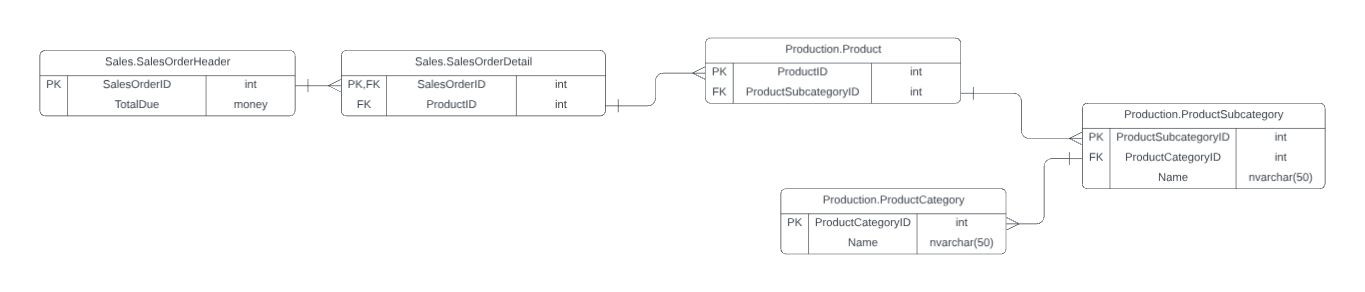

In [ ]:
use AdventureWorks2017
SELECT
    pc.Name AS ProductCategory,
    SUM(soh.TotalDue) AS TotalRevenue
FROM 
    Sales.SalesOrderHeader soh
INNER JOIN 
    Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
INNER JOIN 
    Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN 
    Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN 
    Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY 
    pc.Name
ORDER BY 
    TotalRevenue DESC


## Q3 (medium)

Write a query that returns the total sales amount for each product category

Tables Involved: dbo.FactInternetSales, dbo.dimProduct, dbo.DimProductSubcategory, dbo.DimProductCategory

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

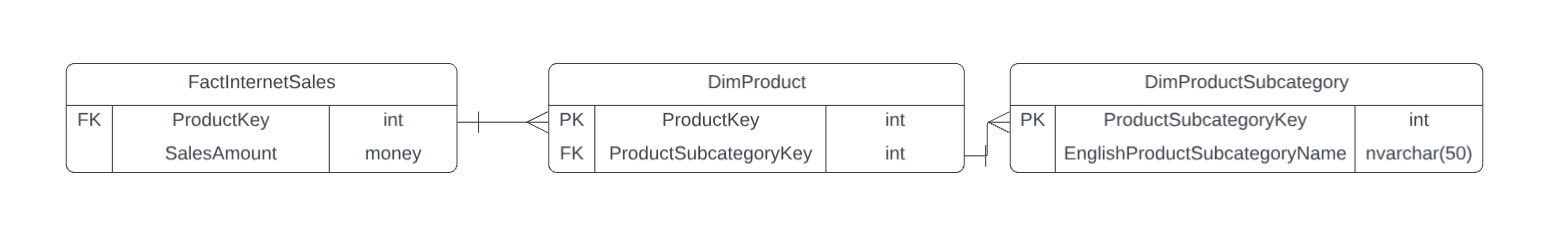

In [ ]:
use AdventureWorksDW2017
SELECT 
    pc.EnglishProductCategoryName, SUM(fis.SalesAmount) AS TotalSalesAmount
FROM 
    dbo.FactInternetSales AS fis
INNER JOIN 
    dbo.DimProduct AS dp ON fis.ProductKey = dp.ProductKey
INNER JOIN 
    dbo.DimProductSubcategory AS dpsc ON dp.ProductSubcategoryKey = dpsc.ProductSubcategoryKey
right JOIN 
    dbo.DimProductCategory AS pc ON dpsc.ProductCategoryKey = pc.ProductCategoryKey
GROUP BY 
    pc.EnglishProductCategoryName;



## Q6 (medium)

Write a query that returns the number of orders and the total amount spent by each customer

Tables Involved: Sales.Orders, Sales.OrderLines, Sales.Customers

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

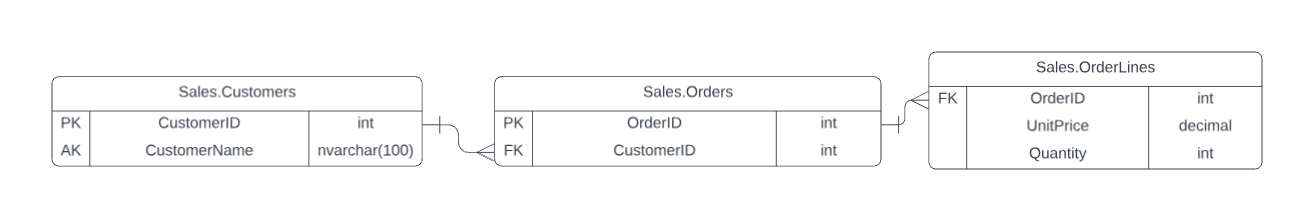

In [ ]:
use WideWorldImporters
SELECT 
    c.CustomerName,
    COUNT(o.CustomerID) AS OrderCount,
    SUM(sod.Quantity * sod.UnitPrice) AS TotalSpent
FROM 
    Sales.Orders o
INNER JOIN 
    Sales.OrderLines sod ON o.OrderID = sod.OrderID
INNER JOIN 
    Sales.Customers c ON o.CustomerID = c.CustomerID
GROUP BY 
    c.CustomerName
ORDER BY 
    TotalSpent DESC;


## Q8(medium)

Write a query that returns the number of orders and total money spent from each customer

Tables Involved: Fact.Order, Dimension.Customer, Fact.Sale

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

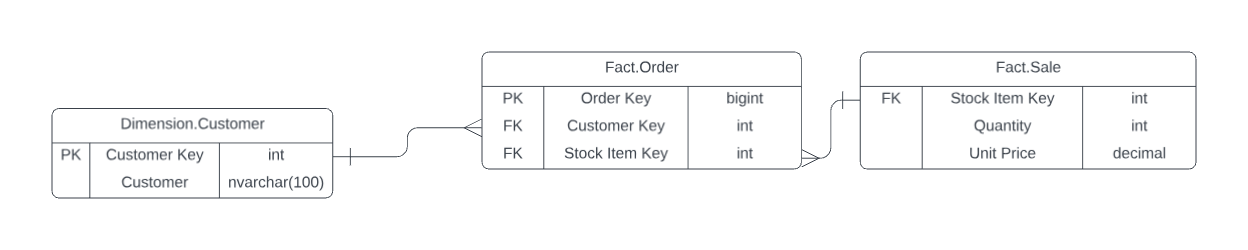

In [ ]:
use WideWorldImportersDW
SELECT 
    c.[Customer],
    COUNT(o.[Order Key]) AS OrderCount,
    SUM(ol.[Unit Price] * ol.[Quantity]) AS TotalSpent
FROM 
    Fact.[Order] o
INNER JOIN 
    Dimension.Customer c ON o.[Customer Key] = c.[Customer Key]
INNER JOIN 
    Fact.Sale ol ON o.[Stock Item Key] = ol.[Stock Item Key]
WHERE
    Customer <> 'unknown'
GROUP BY 
    c.[Customer]
ORDER BY 
    TotalSpent DESC;



## Q9(medium)

Write a query that returns the products total sales amount

Tables Involved: Fact.Order, Fact.Sale

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

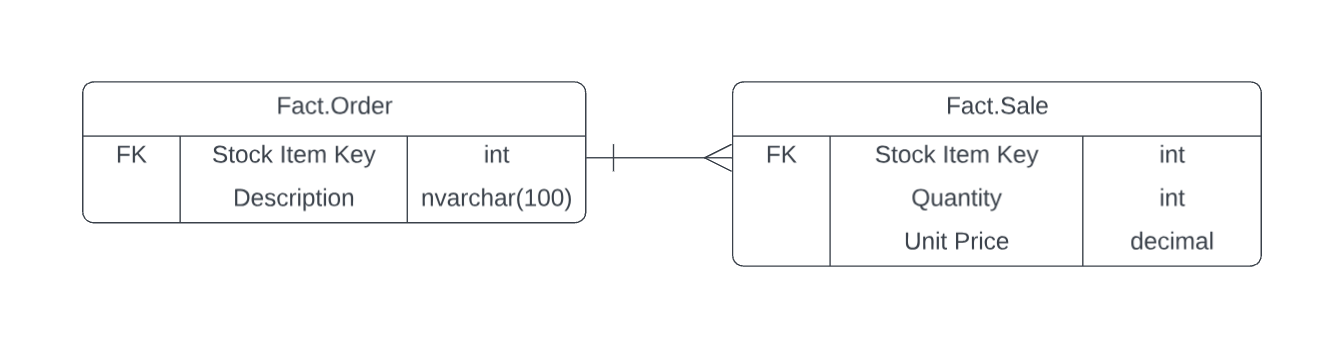

In [ ]:
use WideWorldImportersDW
SELECT 
    o.[Stock Item Key],
    o.[Description],
    SUM(ol.[Unit Price] * ol.[Quantity]) AS TotalSalesAmount
FROM 
    Fact.[Order] o
INNER JOIN 
    Fact.[sale] ol ON o.[Stock Item Key] = ol.[Stock Item Key]
GROUP BY 
    o.[Stock Item Key],
    o.[Description]
ORDER BY 
    TotalSalesAmount;


## Q10(medium)

Write a query that returns the top 3 sales people  based on the total sales amount for the year 2016

Tables Involved: Fact.Sale, Dimension.Employee

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

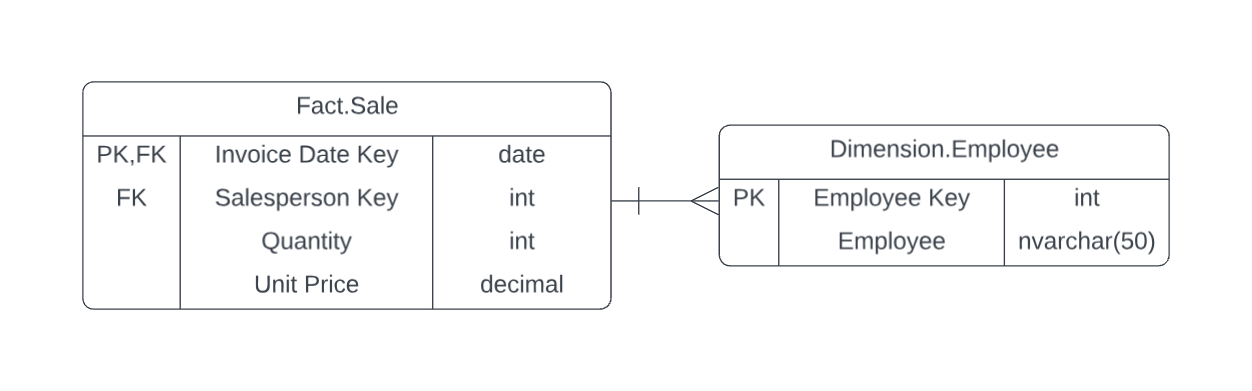

In [ ]:
use WideWorldImportersDW
;WITH SalesPerSalesperson AS (
    SELECT 
        e.[Employee Key],
        e.Employee,
        SUM(Quantity*[Unit Price]) AS TotalSalesAmount
    FROM 
        Fact.Sale f
    INNER JOIN 
        Dimension.Employee e ON f.[Salesperson Key] = e.[Employee Key]
    WHERE 
        year(f.[Invoice Date Key]) = 2016
    GROUP BY 
        e.[Employee Key],
        e.Employee
)

SELECT TOP 3
    Employee AS SalespersonName,
    TotalSalesAmount
FROM 
    SalesPerSalesperson
ORDER BY 
    TotalSalesAmount DESC;



## Q11 (complex)

Write a query that returns the total sales amount for each region

Tables Involved: Sales.Order, Sales.OrderDetail, Sales.Customer

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

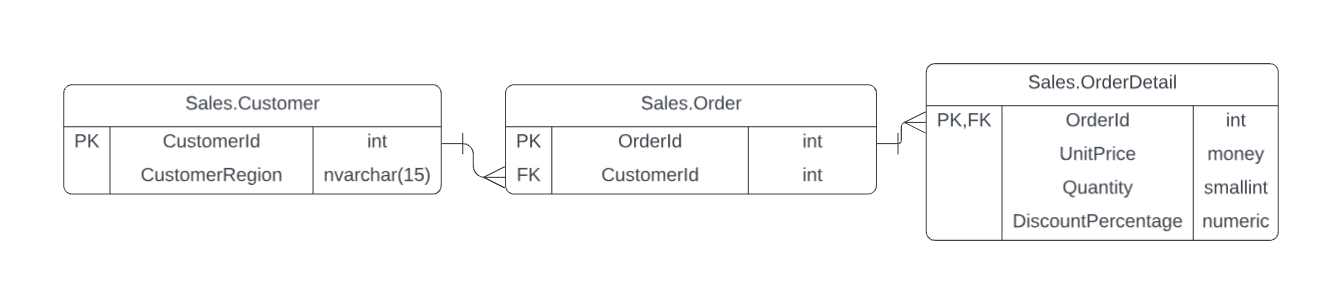

In [ ]:
use Northwinds2022TSQLV7
;WITH SalesCTE AS (
    SELECT 
        O.OrderID,
        O.CustomerID,
        C.CustomerRegion,
        OD.Quantity,
        OD.UnitPrice,
        OD.DiscountPercentage,
        OD.Quantity * (OD.UnitPrice * (1 - OD.DiscountPercentage)) AS LineTotal
    FROM 
        Sales.[Order] O
    INNER JOIN 
        sales.[OrderDetail] OD ON O.OrderID = OD.OrderID
    INNER JOIN 
        Sales.Customer C ON O.CustomerID = C.CustomerID
),

DiscountedSalesCTE AS (
    SELECT 
        OrderID,
        CustomerID,
        CustomerRegion,
        SUM(LineTotal) AS TotalSales
    FROM 
        SalesCTE
    GROUP BY 
        OrderID,
        CustomerID,
        CustomerRegion
),

RegionSales AS (
    SELECT 
        CustomerRegion,
        SUM(TotalSales) AS TotalRegionSales
    FROM 
        DiscountedSalesCTE
    GROUP BY 
        CustomerRegion
)

SELECT 
    rs.CustomerRegion,
    rs.TotalRegionSales
FROM 
    RegionSales rs
where CustomerRegion is not null
ORDER BY 
    rs.TotalRegionSales DESC;


## Q13 (medium)

Write a query that returns the total quantity sold and the average sales per product

Tables Involved: Sales.OrderDetail, Production.Product

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

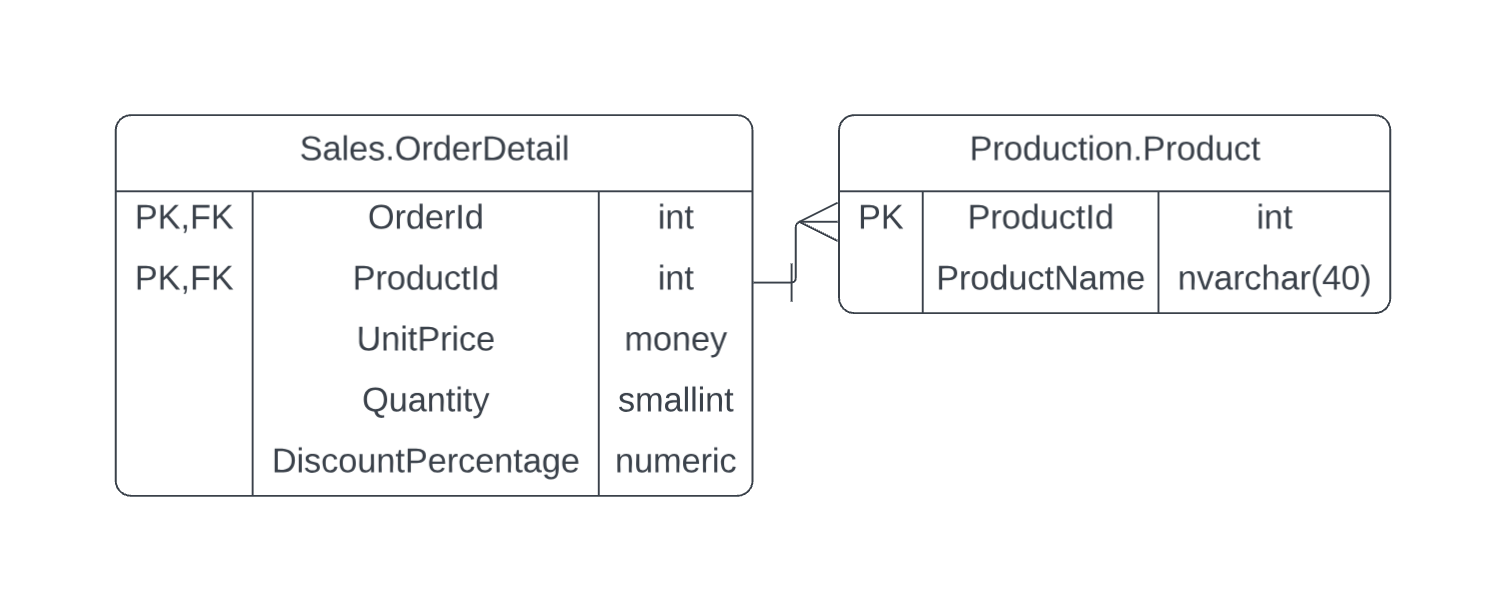

In [ ]:
USE Northwinds2022TSQLV7;
WITH OrderDetailsExtended AS (
    SELECT
        OD.OrderID,
        OD.ProductID,
        OD.UnitPrice,
        OD.Quantity,
        OD.DiscountPercentage,
        (OD.UnitPrice * OD.Quantity - (OD.UnitPrice * OD.Quantity * OD.DiscountPercentage)) AS TotalPrice
    FROM
        Sales.[OrderDetail] OD
)

SELECT
    P.ProductID,
    P.ProductName,
    SUM(ODE.Quantity) AS TotalQuantitySold,
    AVG(ODE.TotalPrice) AS AvgSalesPerProduct
FROM
    Production.Product P
INNER JOIN
    OrderDetailsExtended ODE ON P.ProductID = ODE.ProductID
GROUP BY
    P.ProductID,
    P.ProductName;

## Q14 (medium)

Write a query that returns the average price for each category

Tables Involved: Production.Category, Production.Product

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

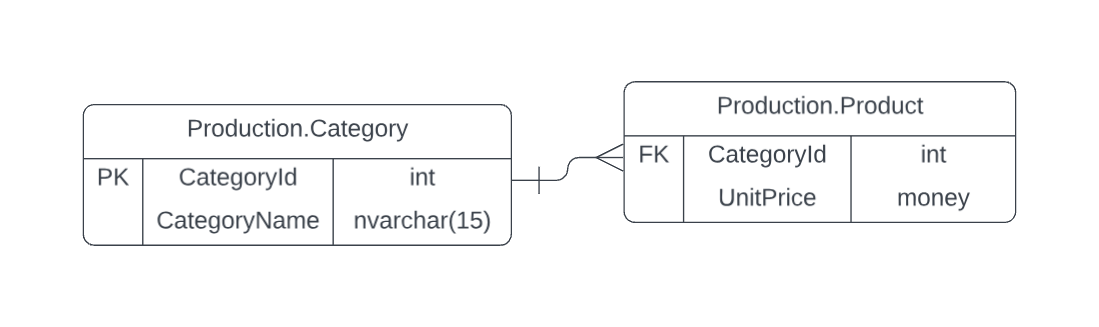

In [ ]:
use Northwinds2022TSQLV7
;WITH CategoryAveragePrice AS (
    SELECT
        c.CategoryName,
        AVG(p.UnitPrice) AS AverageUnitPrice
    FROM
        Production.Product p
    INNER JOIN
        Production.Category c ON p.CategoryID = c.CategoryID
    GROUP BY
        c.CategoryName
)

SELECT
    CategoryName,
    AverageUnitPrice
FROM
    CategoryAveragePrice
ORDER BY
    AverageUnitPrice DESC


## Q15 (medium)

Write a query that returns the total sales amount in each country

Tables Involved: Sales.Order, Sales.OrderDetail, Sales.Customer

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

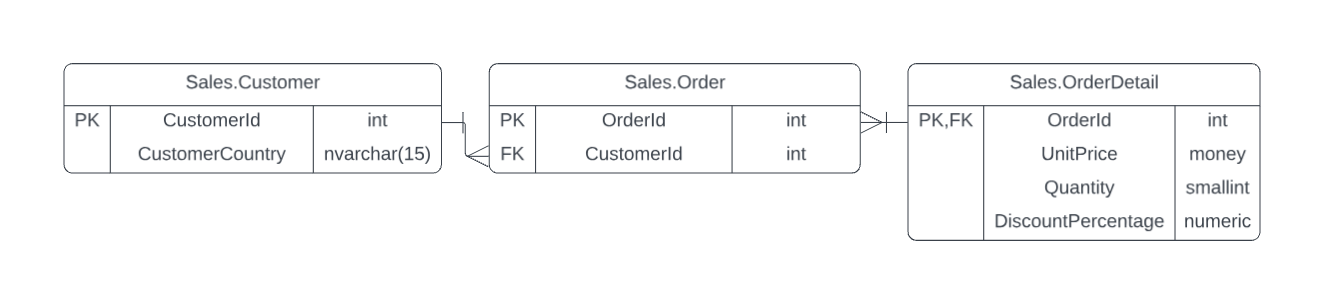

In [ ]:
use Northwinds2022TSQLV7
SELECT
    CASE
        WHEN co.CustomerCountry IS NULL THEN 'Unknown'
        ELSE co.CustomerCountry
    END AS Country,
    SUM(od.UnitPrice * od.Quantity - (od.UnitPrice * od.Quantity * od.DiscountPercentage)) AS TotalSales
FROM
    Sales.[Order] o
INNER JOIN
    [Sales].OrderDetail od ON o.OrderID = od.OrderID
LEFT JOIN
    Sales.Customer c ON o.CustomerID = c.CustomerID
LEFT JOIN
    (
        SELECT
            CustomerCountry
        FROM
            Sales.Customer
        WHERE
            CustomerCountry IS NOT NULL
    ) co ON c.CustomerCountry = co.CustomerCountry
GROUP BY
    co.CustomerCountry
ORDER BY
    TotalSales DESC;


## Q16 (medium)

Write a Query that returns the total number of each product sold

Tables Involeved: Warehouse.StockItems, Sales.OrderLines

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

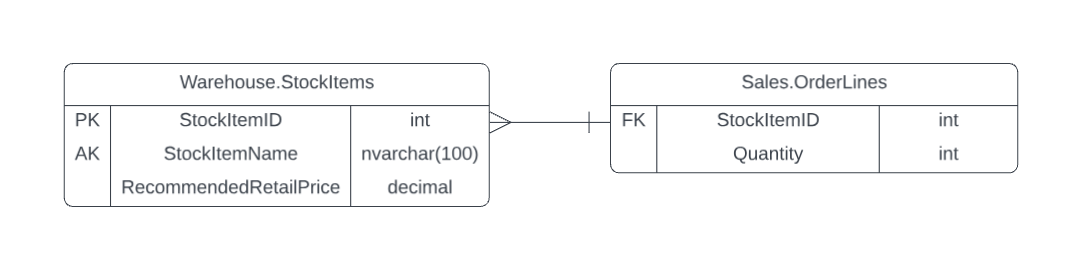

In [ ]:
use WideWorldImporters
;WITH SoldProductsCTE AS (
    SELECT
        p.StockItemID,
        p.StockItemName,
        p.RecommendedRetailPrice,
        SUM(od.Quantity) AS TotalQuantitySold
    FROM
        Warehouse.StockItems p
    LEFT JOIN
        Sales.OrderLines od ON p.StockItemID = od.StockItemID
    GROUP BY
        p.StockItemID,
        p.StockItemName,
        p.RecommendedRetailPrice
)

SELECT
    StockItemID,
    StockItemName,
    RecommendedRetailPrice,
    TotalQuantitySold
FROM
    SoldProductsCTE
    
order by TotalQuantitySold



## Q17 (complex)

Write a query that finds the orders placed on the weekends

Tables Involved: Fact.Order, Dimension.Customer, Fact.Sale

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

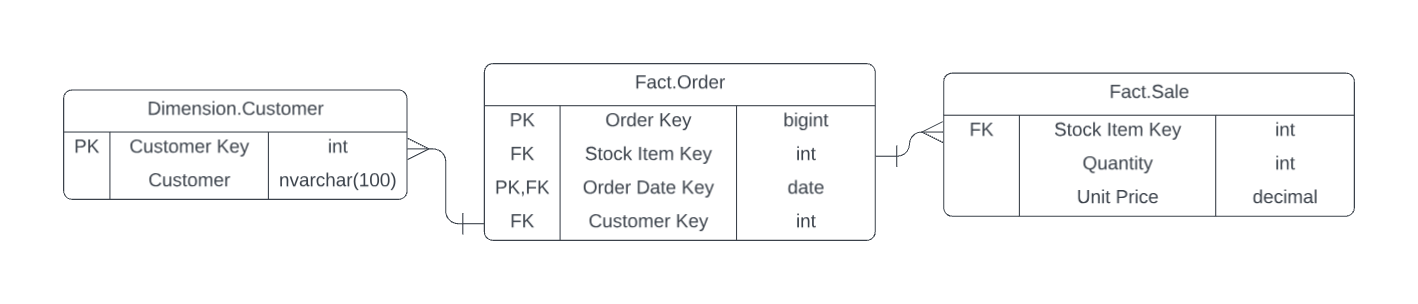

In [ ]:
use WideWorldImportersDW;
WITH WeekendOrdersCTE AS (
    SELECT
        O.[Order Key],
        O.[Order Date Key],
        DATEPART(WEEKDAY, O.[Order Date Key]) AS DayOfWeek,
        C.Customer,
        SUM(s.Quantity * s.[Unit Price]) AS TotalOrderAmount
    FROM
        Fact.[Order] O
    INNER JOIN
        Dimension.Customer C ON O.[Customer Key] = C.[Customer Key]
    INNER JOIN
        Fact.[sale] s ON o.[Stock Item Key] = s.[Stock Item Key]
    GROUP BY
        O.[Order Key],
        O.[Order Date Key],
        C.Customer
    HAVING
        DATEPART(WEEKDAY, O.[Order Date Key]) IN (1, 7) -- Saturday or Sunday
)

SELECT
    O.[Order Key],
    O.[Order Date Key],
    O.DayOfWeek,
    C.Customer,
    O.TotalOrderAmount
FROM
    WeekendOrdersCTE O
INNER JOIN
    Dimension.Customer C ON O.Customer = C.Customer
where c.Customer <> 'unknown'




## Q19 (complex)

Write a Query that Finds the average order quantity for each product category

Tables Involved: Production.ProductCategory, Production.Product, Production.ProductSubcategory

\*<span style="color: var(--vscode-foreground); font-family: -apple-system, BlinkMacSystemFont, sans-serif;">Written in collaboration with ChatGPT from OpenAI to improve understanding and assist with the explanation of the query*</span>  

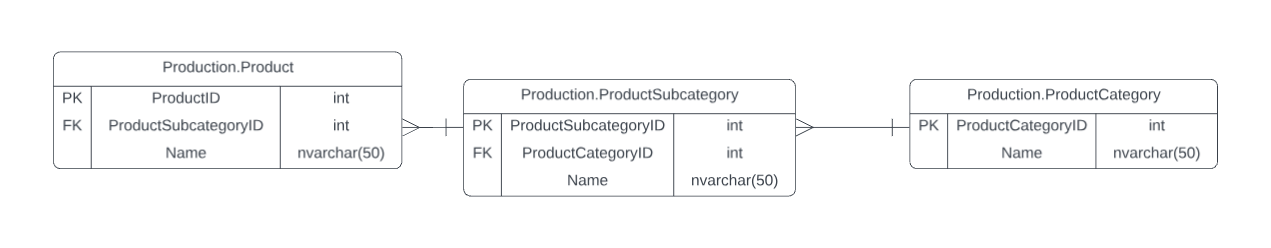

In [ ]:
use AdventureWorks2017
go

drop FUNCTION if EXISTS dbo.GetTotalOrderQuantityForProduct
go

CREATE FUNCTION dbo.GetTotalOrderQuantityForProduct (@ProductID INT)
RETURNS INT
AS
BEGIN
    DECLARE @TotalQuantity INT;

    SELECT @TotalQuantity = SUM(OrderQty)
    FROM Sales.SalesOrderDetail
    WHERE ProductID = @ProductID;

    RETURN @TotalQuantity;
END;
GO

-- Using the custom scalar function in a query
WITH ProductCategorySales AS (
    SELECT
        Ps.name AS ProductSubCategory,
        pc.name as ProductCategory,
        P.ProductID,
        P.Name AS ProductName,
        dbo.GetTotalOrderQuantityForProduct(P.ProductID) AS TotalOrderQuantity
    FROM 
        Production.ProductSubcategory Ps
    INNER JOIN 
        Production.ProductCategory PC ON PS.ProductCategoryID = PC.ProductCategoryID
    INNER JOIN 
        Production.Product P ON P.ProductSubcategoryID = PS.ProductSubcategoryID
    
)

SELECT
    ProductSubCategory, ProductCategory,
    AVG(TotalOrderQuantity) AS AvgOrderQuantityPerCategory
FROM 
    ProductCategorySales
GROUP BY
    ProductSubCategory, ProductCategory
HAVING 
    avg(TotalOrderQuantity) is not null
order by 
    AvgOrderQuantityPerCategory desc;

